In [1]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import json

import cmocean.cm as cmo
import matplotlib.pyplot as plt
from matplotlib import ticker
import scipy.signal as sig
from shapely.geometry import LineString, MultiPoint
from shapely import convex_hull

import flim_processing as fp
import flim_analysis as fa
import flim_geometry as fg
import flim_chemistry as fc
import flim_ui as fui
from ivium import IviumFile

mass_particle_AC = 0.35e-6
radius_particle_AC = 454.5e-6
surface_area_AC = 2.6e-6
volume_AC = 39.46e-9
diff_OH = 5.270e-9
area_channel = 4e-3**2
nu_water = 1e-6
pixel_size = 9.09e-6

In [13]:
data_folder = r"D:\[Code]\paper01\data"
figures_folder = r"D:\[Code]\paper01\figures"

# Loading Current Data

In [3]:
"""FLIM data"""
current_data = fp.open_flim(
    os.path.join(data_folder, "current_p.npz"),
    property_modifications={"lifetime_phase": 1000, "value": 1000},
)

"""Features"""
current_features = fg.load_features(
    data_folder, "current_features.shp", "current_features.npz"
)
current_particle = [f for f in current_features if f.name == "particle"][0]
current_wall = [f for f in current_features if f.name == "wall"][0]
current_membrane = [f for f in current_features if f.name == "membrane"][0]
current_volume = [f for f in current_features if f.name == "volume"][0]

extent = fa.get_extent(current_data["value"][0], 9.09, 1e-3)
geom_extent = [
    0,
    current_data["intensity"][0].shape[1],
    0,
    current_data["intensity"][0].shape[0],
]

"""Open flim .json"""
with open(os.path.join(data_folder, "current.json"), "r") as file:
    current_info = json.load(file)
current_timestamps_flim = np.array(
    list(current_info["FLIMIMAGE"]["TIMESTAMPS in ms"].values())
)
current_delta_t_flim = current_timestamps_flim[1] * 1e-3

"""Load Potential and Current data from ivium file"""
current_ivium = IviumFile()
current_ivium.set_path(os.path.join(data_folder, "current_ivium1420.csv"))
current_ivium.read_data_from_file()

"""Timestamps"""
current_time_stamps = np.array([1000, 180, 240, 300, 360, 420, 480, 540, 600, 660])
current_flim_frames = fp.timestamp2frame_flim(
    current_time_stamps, current_info, offset_flim=-5
)["flim_frames"]

"""Results"""
current_results = pd.read_csv(
    os.path.join(data_folder, "current_results.csv"),
    index_col=0,
)

In [4]:
distance_end_point = 200

current_base_points = fa.get_points_along_line_number(
    current_particle.geometry.exterior, 360
)  # type:ignore
current_rays = fg.get_rays_of_sphere_like_base_points(
    current_base_points, bearing_pulling_factor=5
)

for i_ray, ray in enumerate(current_rays):
    ray.set_end_point_image(current_data["intensity"][0])
    ray.set_end_point_volume(current_volume.geometry)
    ray.set_end_point(distance_end_point)

current_ray_lines = []
for ray in current_rays:
    line = LineString([ray.base_point, ray.end_point_image])
    current_ray_lines.append(line)

90.0 76.4121410146139
89.0 79.17194249586737
88.0 76.58329674588765
87.0 73.55283430474537
86.0 72.62087712946834
85.0 71.52161833850028
84.0 69.73278419515412
83.0 68.53555575048358
82.0 66.45263714799034
81.0 63.703169400047784
80.0 60.636072482338136
79.0 59.535455723053076
78.0 61.45433744228353
77.0 63.13945547425982
76.0 65.53748457567178
75.0 69.59412217093382
74.0 71.96200465087134
73.0 69.82905849604845
72.0 71.43330221052395
71.0 68.89312589177086
70.0 68.07405180298736
69.0 68.9374630919375
68.0 66.56814318954389
67.0 70.03008048356662
66.0 67.5167615272523
65.0 67.75060720930014
64.0 67.1563915531043
63.0 65.53551970815727
62.0 63.30550707302507
61.0 63.61173227345773
60.0 66.29862064441329
59.0 65.36523377747045
58.0 65.37284800924601
57.0 65.4410693201284
56.0 61.224194477981825
55.0 58.3336278871372
54.0 58.74188505482226
53.0 55.766609219195686
52.0 58.289210691238736
51.0 56.766331800931766
50.0 56.581364882642106
49.0 62.335153396336466
48.0 54.2994618185499
47.0 56.4

# Loading Flow Data

In [5]:
"""FLIM data"""
flow_data = fp.open_flim(
    os.path.join(data_folder, "flow_p.npz"),
    property_modifications={"lifetime_phase": 1000, "value": 1000},
)

"""Features"""
flow_features = fg.load_features(data_folder, "flow_features.shp", "flow_features.npz")
flow_particle = [f for f in flow_features if f.name == "particle"][0]
flow_wall = [f for f in flow_features if f.name == "wall"][0]
flow_membrane = [f for f in flow_features if f.name == "membrane"][0]
flow_volume = [f for f in flow_features if f.name == "volume"][0]

extent = fa.get_extent(flow_data["value"][0], 9.09, 1e-3)
geom_extent = [
    0,
    flow_data["intensity"][0].shape[1],
    0,
    flow_data["intensity"][0].shape[0],
]

"""Open flim .json"""
with open(os.path.join(data_folder, "current.json"), "r") as file:
    flow_info = json.load(file)
flow_timestamps_flim = np.array(
    list(flow_info["FLIMIMAGE"]["TIMESTAMPS in ms"].values())
)
flow_delta_t_flim = flow_timestamps_flim[1] * 1e-3

"""Load Potential and Current data from ivium file"""
flow_ivium = IviumFile()
flow_ivium.set_path(os.path.join(data_folder, "flow_ivium1430.csv"))
flow_ivium.read_data_from_file()

"""Timestamps"""
flow_time_stamps = np.array([0, 1, 2, 3, 4, 5, 6, 7]) * 60
t_start = 5  # seconds
t_offset = 55
delta_t = 10
t_eval = flow_time_stamps + t_start + t_offset
flow_flim_frames = fp.timestamp2frame_flim(
    t_eval, flim_info=flow_info, offset_flim=-t_start
)["flim_frames"][::-1]
flows = np.array([2, 1.5, 1.2, 1, 0.8, 0.5, 0.3, 0.1])[::-1]
Res = flows / 60 * 1e-6 / area_channel * 2 * radius_particle_AC / nu_water
Sc = nu_water / diff_OH
Pes = Res * Sc

"""Results"""
flow_results = pd.read_csv(
    os.path.join(data_folder, "flow_results.csv"),
    index_col=0,
)

In [6]:
distance_end_point = 200

flow_base_points = fa.get_points_along_line_number(
    flow_particle.geometry.exterior, 360
)  # type:ignore
flow_rays = fg.get_rays_of_sphere_like_base_points(
    flow_base_points, bearing_pulling_factor=5
)

for i_ray, ray in enumerate(flow_rays):
    ray.set_end_point_image(flow_data["intensity"][0])
    ray.set_end_point_volume(flow_volume.geometry)
    ray.set_end_point(distance_end_point)

flow_ray_lines = []
for ray in flow_rays:
    line = LineString([ray.base_point, ray.end_point_image])
    flow_ray_lines.append(line)

90.0 72.37610047017682
88.99722222222222 71.74530430317861
87.99444444444444 71.59626656052103
86.99166666666666 71.09535305663087
85.9888888888889 70.36502401379477
84.98611111111111 68.95492953520335
83.98333333333333 68.08362964636297
82.98055555555555 67.45760837729716
81.97777777777777 66.8210667657832
80.975 65.97641167479208
79.97222222222223 64.28212771862758
78.96944444444445 62.33439606912441
77.96666666666667 61.18521942703751
76.96388888888889 60.52020216884239
75.96111111111111 60.707596464853
74.95833333333333 61.65298968245213
73.95555555555555 62.30522412207807
72.95277777777778 62.921956739012444
71.95 63.7813523642634
70.94722222222222 64.09243095840696
69.94444444444444 63.555053954547816
68.94166666666666 61.9686973332532
67.9388888888889 59.738829724750644
66.9361111111111 57.58066571317784
65.93333333333334 55.9103097805488
64.93055555555556 55.266913624502706
63.92777777777778 55.22038884708843
62.925 54.678937230543
61.92222222222222 53.93246291187182
60.9194444

0 170 280.6441734192395 10.644173419239507
1 140 314.46292856213165 44.46292856213165
2 83 347.98041161380075 77.98041161380075
3 353 87.7781848194104 177.7781848194104
0 330 355 340.4626876391582 -155.91151065197496 -152.23378233486181 [0.00029221 0.0002141  0.0002007  0.00022377 0.00020866 0.00018183
 0.00027875]
1 0 30 15.690385719505192 151.414907698443 154.47509446125164 [0.00040735 0.00042461 0.00031417 0.0003445  0.00035531 0.00026335
 0.00036296]
2 65 90 77.34784961415396 85.25846246956603 86.47338433288809 [0.0003272  0.00034675 0.00024021 0.00026873 0.00028916 0.00023886
 0.00027137]
3 100 130 114.48469387755101 61.6966994790281 62.02753469033563 [0.00068994 0.00063111 0.00053462 0.00053987 0.00052097 0.00050431
 0.00049291]
4 140 170 152.6300366300366 38.770081848404125 41.43650428439759 [0.0007963  0.00073761 0.00069772 0.00066987 0.00069636 0.00067736
 0.00068162]


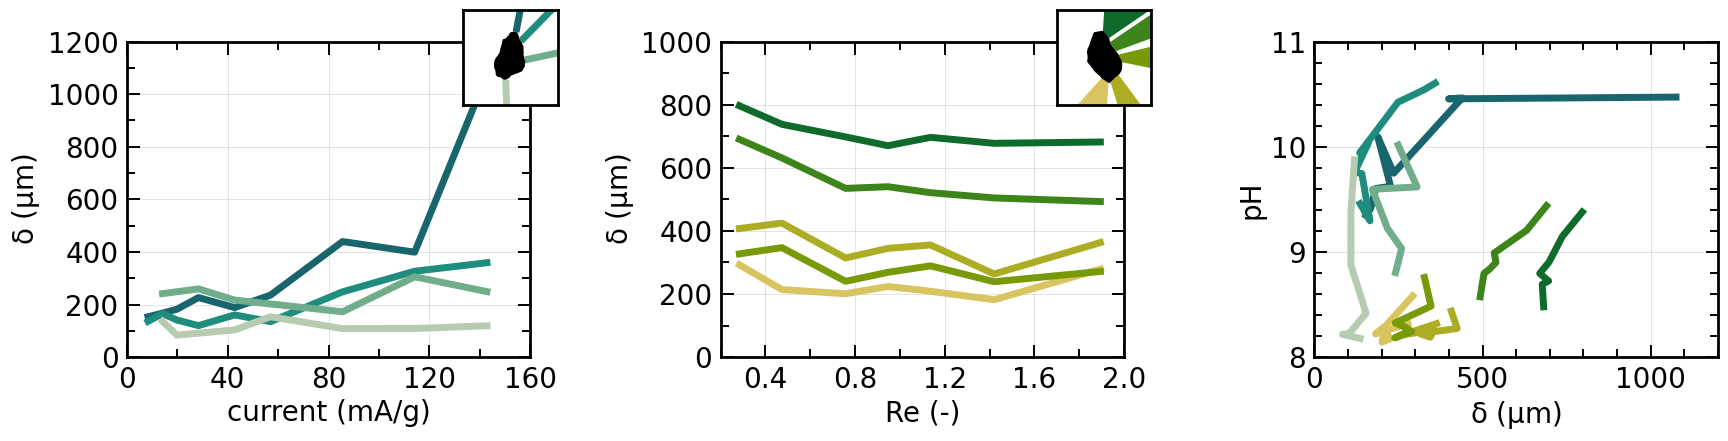

In [28]:
fig, axes = plt.subplots(1, 3, figsize=(17.8, 5))

"""Comparison"""
ax2 = axes.ravel()[2]
ax2.set_xlabel(r"$\delta$ ($\mu$m)")
ax2.set_ylabel("pH")
ax2.set_xlim(0, 1200)
ax2.set_ylim(8, 11)


"""Current"""
# settings
current_chosen_ray_numbers = [-6, 83, 140, 170]  # 20, 83, 110,
current_chosen_ray_numbers.reverse()

current_cmap = plt.get_cmap("cmo.tempo")  # type:ignore
current_colors = list(
    current_cmap(np.linspace(0.2, 0.7, len(current_chosen_ray_numbers)))
)
current_colors.reverse()
inset_margin = 1.5


# setup
ax = axes.ravel()[0]
ax.set_xlabel("current (mA/g)")
ax.set_ylabel(r"$\delta$ ($\mu$m)")
ax.set_xlim(0, 160)
ax.set_ylim(0, 1200)
ax.xaxis.set_major_locator(ticker.MultipleLocator(40))
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(2))

ax.yaxis.set_major_locator(ticker.MultipleLocator(200))
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator(2))

ax_ = ax.inset_axes(bounds=[0.8, 0.8, 0.3, 0.3])
current_particle_image = fa.affine_transform_pixel2extent(
    current_particle.geometry, geom_extent, list(extent)
)
ax_.set_xlim(
    current_particle_image.centroid.x - inset_margin,
    current_particle_image.centroid.x + inset_margin,
)
ax_.set_ylim(
    current_particle_image.centroid.y - inset_margin,
    current_particle_image.centroid.y + inset_margin,
)
ax_.grid(alpha=0)
ax_.tick_params(
    which="both",
    left=False,
    right=False,
    bottom=False,
    top=False,
    labelleft=False,
    labelbottom=False,
)


# plot - inset
gpd.GeoSeries(current_particle_image).plot(ax=ax_, color="black")


for i_ray, index_ray in enumerate(current_chosen_ray_numbers):
    ray = current_rays[index_ray]

    if index_ray < 0:
        index_ray += 360 - 1

    print(i_ray, index_ray, ray.angle, fa.angle_image2flow(ray.angle))

    ray_data = current_results[current_results["i_ray"] == index_ray].query(
        "sigma <= 0.7"
    )

    ray_data_bad = current_results[current_results["i_ray"] == index_ray].query(
        "sigma > 0.7"
    )

    ax.plot(
        ray_data.current,
        ray_data.distance * 1e6,
        color=current_colors[i_ray],
        # marker="x",
        # s=80,
    )

    gpd.GeoSeries(
        fa.affine_transform_pixel2extent(ray.base_ray, geom_extent, list(extent))
    ).plot(ax=ax_, color=current_colors[i_ray])

    ax2.plot(
        ray_data.distance * 1e6,
        ray_data.surface_ph,
        color=current_colors[i_ray],
    )

    # mean = ray_data.distance.mean() * 1e6

    # std = ray_data.distance.std() * 1e6

    # ax.axhspan(mean - std, mean + std, alpha=0.15, color=current_colors[i_ray])

    # ax.axhline(y=mean, color=current_colors[i_ray])

"""Flow"""

# settings
flow_angle_start = np.array([10, 70, 130]) + 180
flow_angle_end = np.array([50, 130, 180]) + 180
ray_start = np.array([330, 0, 65, 100, 140])
ray_end = np.array([355, 30, 90, 130, 170])
flow_cmap = plt.get_cmap("cmo.speed")  # type:ignore
flow_colors = list(flow_cmap(np.linspace(0.2, 0.7, len(ray_start))))
inset_margin = 1.5

# setup
ax = axes.ravel()[1]
ax.set_xlabel("Re (-)")
ax.set_ylabel(r"$\delta$ ($\mu$m)")
ax.set_xlim(0.2, 2)
ax.set_ylim(0, 1000)

ax.xaxis.set_major_locator(ticker.MultipleLocator(0.4))
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(2))

ax.yaxis.set_major_locator(ticker.MultipleLocator(200))
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator(2))

ax_ = ax.inset_axes(bounds=[0.8, 0.8, 0.3, 0.3])
flow_particle_image = fa.affine_transform_pixel2extent(
    flow_particle.geometry, geom_extent, list(extent)
)
ax_.set_xlim(
    flow_particle_image.centroid.x - inset_margin,
    flow_particle_image.centroid.x + inset_margin,
)
ax_.set_ylim(
    flow_particle_image.centroid.y - inset_margin,
    flow_particle_image.centroid.y + inset_margin,
)
ax_.grid(alpha=0)
ax_.tick_params(
    which="both",
    left=False,
    right=False,
    bottom=False,
    top=False,
    labelleft=False,
    labelbottom=False,
)

# plot - inset
gpd.GeoSeries(flow_particle_image).plot(ax=ax_, color="black")

for i_ray, (index_ray_start, index_ray_end) in enumerate(zip(ray_start, ray_end)):
    ray_data_full = (
        flow_results.query(f"@index_ray_start <= i_ray < @index_ray_end")
        # .query("sigma <= 0.7")
        .query("delta <= 5")
        .query("delta > 0")
        .groupby(by="flow")
    )
    ray_data_max = ray_data_full.max()
    ray_data_min = ray_data_full.min()
    ray_data = ray_data_full.mean()

    rays = flow_rays[index_ray_start:index_ray_end]
    start_points = [r.base_point for r in rays]
    end_points = [
        fa.get_point_from_angle(r.base_point, r.angle, dist=5000) for r in rays
    ]
    points = start_points + end_points
    hull = convex_hull(MultiPoint(points))
    gpd.GeoSeries(
        fa.affine_transform_pixel2extent(hull, geom_extent, list(extent))
    ).plot(ax=ax_, color=flow_colors[i_ray])
    print(
        i_ray,
        index_ray_start,
        index_ray_end,
        ray_data.i_ray.mean(),
        ray_data.flow_angle.min(),
        ray_data.flow_angle.max(),
        ray_data.distance.values,
    )

    ax.plot(
        ray_data.index / 60 * 1e-6 / area_channel * 2 * radius_particle_AC / nu_water,
        ray_data.distance * 1e6,
        color=flow_colors[i_ray],
        # marker="x",
        # s=80,
    )
    ax2.plot(
        ray_data.distance * 1e6,
        ray_data.surface_ph,
        color=flow_colors[i_ray],
        #s = 30,
    )

    # mean = ray_data.distance.mean() * 1e6

    # std = ray_data.distance.std() * 1e6

    # ax.axhspan(mean - std, mean + std, alpha=0.15, color=current_colors[i_ray])

    # ax.axhline(y=mean, color=current_colors[i_ray])

plt.tight_layout()
fig.savefig(os.path.join(figures_folder, "figure05.pdf"), dpi=200)
plt.show()

In [8]:
current_index = 8
print(current_results.current.unique()[current_index])
current_results_frame = current_results.query(
    f"current == {current_results.current.unique()[current_index]}"
).query("sigma < 0.6")
current_results_frame.shape

114.14


(273, 17)

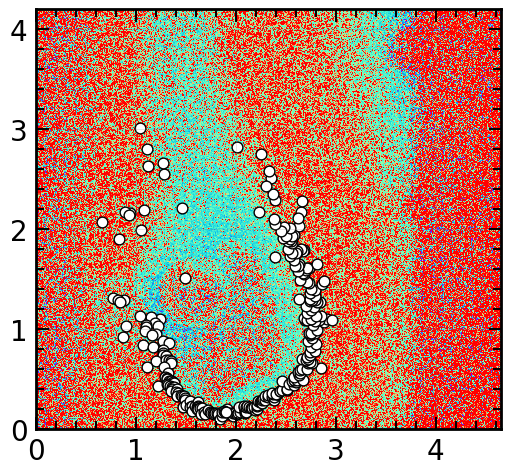

In [10]:
fig, ax = plt.subplots()
img = ax.imshow(
    current_data["value"][current_flim_frames[current_index]],
    cmap="rainbow_r",
    vmin=8,
    vmax=12,
    extent=extent,
)

geoms = []
for i_ray, index_ray in enumerate(current_results_frame.i_ray.unique()):
    ray = current_rays[index_ray]
    ray_data = current_results_frame.loc[current_results_frame.i_ray == index_ray].iloc[
        0
    ]
    layer_end_point = fa.get_point_from_angle(
        ray.base_point, ray.angle, ray_data.distance / pixel_size
    )
    geoms.append(
        fa.affine_transform_pixel2extent(layer_end_point, geom_extent, list(extent))
    )

gpd.GeoSeries(geoms).plot(
    ax=ax, facecolor="white", edgecolor="black", markersize=60, alpha=1
)
plt.show()

In [ ]:
numerator_list = ["A", "B", "C", "D"]
v_alignments = ["center", "center", "baseline", "bottom"]
h_alignments = ["center", "center", "center", "center"]